# 第二章 Java内存区域与内存溢出异常

## Java内存分类

Java的内存可以分为为两大类：

1. 线程隔离区域：这个区域中不同线程对应的内存区域是分开的，彼此是相互隔离的，主要是三个区域：
   1. 程序计数器：主要用于指示程序运行的位置，是一个累加器一样的东西。应用场景是在多线程并发，线程切换时能够让线程在程序计数器的作用下找到程序执行的位置。因此不同线程的程序计数器是彼此隔离的。
   2. Java虚拟机栈：这个区域也是线程隔离的，也叫做Java栈，用于维护各个线程中的方法内存模型，每个方法在执行时会向虚拟机栈中压入一个栈帧，该栈帧中用于存储**局部变量表**，**操作数栈**，**动态链接**等信息。Java中常说的堆栈中的栈指的就是Java虚拟机栈。
   3. 本地方发栈：该栈的作用和Java虚拟机栈类似，但是作用的方法对象不是Java方法，而是本地方法，也就是第三方库提供的。
2. 非线程隔离的区域：这个区域中不同线程的内存是相互可以访问的，主要是两个区域：
   1. Java堆（Heap）：这个内存区域中主要存放各种类型的Java对象，也是Java虚拟机管理的最大一部分内存。Java堆可以是一块连续的内存，也可以是物理上不连续但是逻辑上连续的内存。在Java堆中不同的线程可以共享堆内存，但这可能会引发竞争条件（即A线程的对象释放了某个堆内存，但是在其还没有释放完成时B对象就引用了该内存），也可以将堆内存进行划分，给各线程分别使用，这种技术叫做TLAB.
   2. 方法区：该区域用于存放Java类中的类信息，常量，静态变量等等数据。在方法区中还有一块特殊的区域叫做运行时常量池，与一般的常量和变量必须在编译时就确定不同，运行时常量池可以在程序运行期间加入常量，例如使用`String.intern();`就能实现运行时将常量加入到方法区也就是运行时常量池中。

## 一个对象的创建流程

一个对象的创建流程大致可以做以下表述：

1. Java虚拟机首先检查该类是否被装载（load），如果没有则装载该类。一个类一旦被装载就将得知其所需内存大小。

2. 类被装载过后就要进行内存申请，内存申请有两种方式：
   1. 指针碰撞：这种方式中堆内存是绝对规整的，也就是说使用过的内存在逻辑上被放在一边，没有使用过的逻辑上被放在另一边，两个区域使用一个内存指针隔开，当需要进行新的内存申请时只需要把内存指针偏移指定的距离即可。
   2. 空闲列表：这种方式堆内存并不是规整的，Java会维护一个空闲内存表，需要申请内存时只是在空闲内存表中找到一块足够大的空间分配给对象。
   
   具体采取哪种内存分配策略取决于Java的垃圾回收器是否带有内存压缩机制。
   
   同时，在多线程并发申请内存时还可能出现内存申请竞争条件，有两个方法来避免这种情况：
   1. 对线程申请内存操作进行同步处理。
   2. 将不同的线程申请的内存区域隔离开，也就是TLAB技术。不同线程申请的内存区域是不重叠的，也就避免了内存申请的竞争条件。
3. Java虚拟机将对申请好内存的对象一些列初始化操作，具体包含两个类型的操作：
   1. 进行零值化操作，也就是将所有的布尔型变量初始化为`false`。
   2. 对类的对象头进行设置，对象头中包含了类的许多重要信息，包括元数据信息，哈希值等等。
4. 最后，再由Java虚拟机运行对象的构造方法，对对象进行必要的初始化操作。

## 对象的内存布局

一个对象的内存主要分为三个部分：

1. 对象头：对象头中存储着对象的重要信息，对象头主要由以下两个部分的信息组成：
   1. 第一部分用于存储运行时数据，包括哈希值，锁状态标志，偏向线程ID等等。
   2. 第二部分用于存储其类型指针，这个指针指向其类的元数据，用于说明该对象是哪个类的实例化结果。
2. 实例数据：这个区域主要用于存放实例对象的各种变量。
3. 对齐填充：这个区域不是必须存在的，它主要起到内存占位的作用。这是由于某些Java虚拟机要求对象的内存必须是8字节的整数倍，因此就会有这样的占位内存来满足Java虚拟机的要求。

一个对象如何索引到其实例变量和类变量呢？主要是通过Java虚拟机栈中本地变量表中的一个`ref`指针（其实就是`this`指针），使用该指针来索引变量，主要有两种方法：

1. 采用句柄的方法：`ref`指针指向Java堆的一个特定区域，该区域中记录着每个Java对象变量和类变量（主要是方法区中常量和静态变量）的起始位置，以此来达到索引的目的：
2. 采用直接指针：`ref`指针直接指向Java堆中对象实例变量的内存起始位置，该内存中不仅仅有变量值还有一个指针指向方法区中类变量（只要是常量和静态变量）的起始位置。

# 第三章 垃圾收集器与内存分配策略

本章主要讲了Java虚拟机中垃圾回收的一些机制，包括垃圾回收算法，回收算法的实现，回收的大致步骤以及内存分配时候的一些规定。对于之前不懂Java虚拟机内部实现的人来说还是大有帮助的，颠覆了一些之前想当然的观念，比如说Java的自动垃圾回收机制是基于引用计数的方式实现的。

## Java中的引用类型和可达性分析

Java中的自动垃圾回收机制不是使用引用计数实现的，而是使用“可达性”分析的方法。这种方法简而言之就是利用一系列称为`GC Roots`的对象作为起点，从这些起点开始向下搜索，所走过的路径称为引用链，当一个对象没有和任何一个`GC Root`对象通过引用链相连时就说明这个这个对象是不可用的，证明是可以被回收的。Java中能被称之为`GCRoots`对象的有以下四类：

* 虚拟机栈（栈帧中的本地变量表）中的引用对象。

* 方法区中类静态属性引用对象。

* 方法区中常量引用的对象。

* 本地方法栈中`JNI`（即一般说的`Native`方法）引用的对象。

Java对象的引用分为四种类型：

* 强引用：这种引用的程度最强，在垃圾回收的过程中，有强引用的对象不会被回收。

* 软引用：比强引用要弱一些，对应那些有用但不是必需的对象，通常在第一次垃圾回收时不会被回收，但是在第二次垃圾回收的过程中会被回收。

* 弱引用：比软引用更加弱势，用于指代那些完全没有用的对象，通常在第一次垃圾回收中就会被回收。

* 虚引用：这种引用没有任何实际意义，仅仅是在垃圾回收的过程中打印出一条记录。

## Java中垃圾回收的一般过程

Java中触发垃圾回收的一般过程都是先进行可达性分析，但是这通常要耗费很多时间，而且在进行分析的过程中通常要将所有的线程执行都停下来，因此这会带来很大的性能损失，通常的步骤是：

1. 虚拟机再运行时在每个安全点进行一次操作，所谓安全点就是程序即将进行长时间运行的时间点，即进入方法调用之前，进入循环之前等等。在安全点线程会将上一个安全点之间的所有引用对象都加入到一个`oopmap`的对象中，这样虚拟机在进行可达性分析的过程中就能够减少扫描范围。安全点的设置有时候过于苛刻，因此通行的做法是在安全区内进行上述操作，安全区是指某一个代码片段，在这个代码片段中引用关系不会发生变化。

2. 触发垃圾回收机制一定在安全点或者安全区，垃圾回收的过程中要将所有的执行线程都停下来，Java虚拟机将会检查所有`GC Root`对象的`oopmap`结构，进行可达性分析，找出不可达的对象来进行垃圾回收。在停止执行线程的方法上有两种中断方式：
   1. 抢占式中断：这种中断方式是强制停止所有的线程，然后再恢复那些没有运行到安全点的线程，让他们运行到安全点再停止。
   2. 主动式中断：这种中断方式不对线程进行具体操作，仅仅是设置一个标志位让各个线程进行轮询，该标志位是一个自陷信号，线程检测到这个信号就会自动挂起
   
3. 当所有线程停止运行Java虚拟机在执行最终的垃圾收集之前还将最后做一次检查，即检查将要被回收对象的`finalize`方法，如果对象实现了这个方法而且没有被虚拟机执行过，那么就会被虚拟机执行这个方法，在这个方法中程序员只要让这个对象再被其他对象引用就能够避免该对象被回收。但是这个方法并不被虚拟机保证执行，而且执行的优先级非常低，因此不推荐这种方式来避免对象被回收。

4. 在对对象进行垃圾回收时有三类算法：
   1. 标记清理算法：这种算法只是简单地将被回收的对象从内存中清除，这种算法将会带来大量的内存碎片，非常不友好。
   2. 复制算法：这种清理算法应用的比较多，一个比较经典的实现是IBM开发的垃圾回收算法，这种算法假定所有的新生代对象大多都是“朝生夕死”，因此将堆中的新生代区域分成了三个部分，一个$Eden$区域和两个$survivor$区域，其中$Eden$区域和$survivor$区域的大小比为8:1，日常只有一个$Eden$区和一个$survivor$区参与内存的分配和回收，另一个$survivor$区空闲。当发生内存回收的时候虚拟机首先将$Eden$和$survivor$区中的对象清除掉，然后将剩余的对象复制到闲置的$survivor$区域中，最后将$Eden$和$survivor$区域的内存清空。如果闲置的$survivor$区域空间不足，将会触发从老年代内存区域中“借”内存的操作。
   3. 标记整理算法：这种算法是针对老年代对象的，老年代对象一般是指那种长期存在，被清理频率很低的对象，他们和新生代对象的存放位置也不一样，虽然都是在堆中，但是在不同的区域。触发老年代对象回收的时候，虚拟机将会把所有的存活对象进行压紧操作，达到清除内存碎片的目的。由于老年代对象的回收不频繁，因此这样的操作带来的性能下降也可以被容忍。

## Java中的内存分配过程

Java中的内存分配也遵循着比较复杂的过程。对象一般在Java堆中进行内存分配，由于虚拟机采用的分代回收算法，虚拟机将堆内存分为新生代和老年代。所谓新生代就是存放那些很快被创建又很快被销毁的对象，这些对象的生命周期一般都很短。老年代对象指的是那些将会较长时间存在的对象。当然，新生代对象和老年代对象并不是人为指定的，而是在运行过程中由虚拟机指定的。

在Java虚拟机中可以用参数来规定虚拟机中新生代区域的大小和老年代区域的大小，新生代区域中一般遵从复制垃圾回收算法，即分配一个$Eden$空间两个$survivor$空间，且$Eden$空间和$survivor$空间的大小之比为8:1。

当一个对象要申请内存时遵循以下步骤：

1. 新生成的对象首先在$Eden$空间中分配内存，如果$Eden$空间不足则会触发垃圾回收，将$Eden$空间中的部分内存释放，同时将活着的对象复制到$survivor$空间中。

2. 如果新生的对象所占内存过于庞大，无法在新生代中安放，或者其大小超过了用户设定的最大值，那么该对象直接会被放入老年代内存区域中。

3. 在新生代区域中存在的对象如果在多次垃圾回收中都未被清理就会被虚拟机标记为长期存在的对象进而被放入老年代区域存储，事实上，每一次垃圾回收的过程都会给未被回收的对象的年龄计数器加一，通常年龄计数器的值大于15就会被认为是老年代对象。

4. 如果在新生代中的对象相同年龄的对象达到了$survivor$空间的一半，那么这些对象就会被放入老年代中。

5. 在复制算法中，算法设计者假定新生代对象在每一次垃圾回收中仅仅有2%被保留，因此$survivor$的空间在整个新生代中只占10%。难免会出现剩余的新生代对象大小大于$survivor$能承载的极限。这时候就要将多余的对象从新生代区域转入老年代区域，如果此时老年代区域的连续内存大于要转入的部分，那么可以直接操作。否则就有可能出现老年代区域装不下新生代对象的情况，这时候虚拟机会尝试着向老年代区域复制，如果失败则启动老年代区域的垃圾回收。

## Java中垃圾回收器

Java虚拟机规范中对垃圾回收器应该如何实现并没有任何规定，因此不同的厂商，不同版本的虚拟机所提供的垃圾收集器可能都会有很大差别。本节的讨论基于HotSpot虚拟机上的垃圾回收器实现，这个虚拟机上包含的所有垃圾收集器如下图所示：

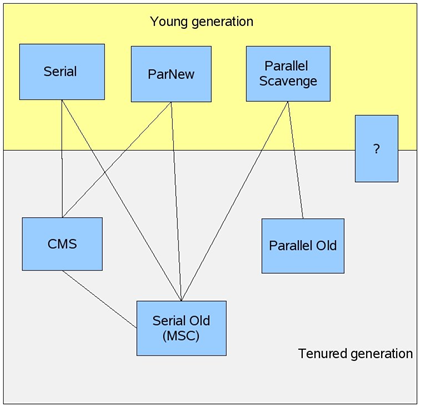

上图表示了Java虚拟机中拥有“新生代”和“老年代”两个区域的内存划分，在HotSpot虚拟机实现的垃圾回收器中有工作在新生代的，例如Serial，ParNew，也有工作在老年代的，例如CMS,Serial Old等等。垃圾收集器之间的连线代表着两个垃圾收集器可以搭配工作或者互为备份，例如Serial和Serial Old收集器就可以搭配工作，分别作为Java虚拟机工作在新生代和老年代的垃圾收集器，而CMS和Serial Old之间的连线代表着Serial Old作为CMS的备份垃圾回收器，一旦CMS在垃圾回收阶段出现了异常，Serial Old就将立即发挥作用。（上图中的？其实代表着G1收集器，这是一个可以工作在新生代和老年代的新型收集器，不知为何这张图将其标记为一个？，可能是要表明这个收集器还没有大规模使用吧）

### Serial / Serial Old垃圾收集器

Serial收集器是最基本，发展历史最悠久的收集器，曾经是新生代垃圾收集器的唯一选择。这是一个**单线程**的垃圾收集器，所谓单线程有两层含义：

* Serial垃圾收集器的垃圾收集是一个单线程模型，意思是说垃圾收集工作只又一个线程完成。

* Serial垃圾收集器在进行垃圾收集时其他所有运行的工作线程需要停下来，在垃圾收集阶段只有一个线程在运行，即垃圾收集线程。

Serial垃圾收集器有两个版本，分别是工作在新生代的Serial收集器，以及工作在老年代的Serial Old收集器，两个收集器可以搭配使用。工作在新生代的Serial收集器采用**复制算法**进行垃圾回收，而工作在老年代的Serial Old收集器采用标记-整理算法进行垃圾回收。这两个收集器搭配工作的示意图如下所示：

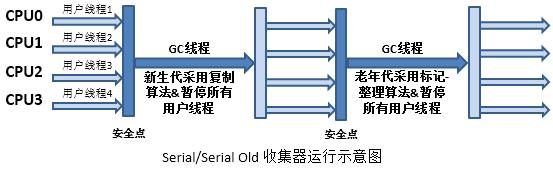

### ParNew收集器

ParNew收集器其实就是Serial收集器的多线程版本，它和Serial新生代收集器的共同点有很多，例如都使用**复制算法**继续拧垃圾回收，进行垃圾回收时都需要将所有的用户线程停止下来，但是区别在于：Serial收集器的垃圾回收线程只有一个，但是ParNew收集器的垃圾回收线程有多个，是一个多线程的垃圾回收器。ParNew收集器在多核CPU的硬件基础上会比单线程的Serial有更好的性能，更重要的是ParNew是新生代中收集器中除了Serial外**唯一**能与CMS收集器搭配工作的新生代收集器，ParNew收集器与Serial Old收集器搭配工作的示意如下图所示：

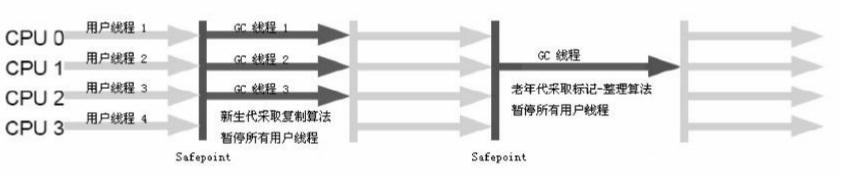

### Parallel Scavenge收集器

Parallel Scavenge收集器与ParNew收集器有很多相似之处，例如他们都是并行的多线程收集器，都使用**复制算法**进行垃圾收集。但是Parallel Scavenge收集器拥有两个特别之处：

1. Parallel Scavenge收集器的设计目标是尽可能达到一个可控制的吞吐量：所谓吞吐量就是指：$吞吐量=\frac{运行用户代码的时间}{运行用户代码的时间 + 垃圾收集的时间}$，除此之外，Parallel Scavnege收集器还可以直接指定最大垃圾收集停顿时间。其中，Parallel Scavnege收集器使用`-XX:MaxGCPauseMillis`来指定最大垃圾收集停顿时间，使用`-XX:GCTimeRatio`来指定垃圾收集的吞吐量。需要注意的是：垃圾收集最大停顿时间和吞吐量之间有着一定的负相关关系，因为吐过最大停顿时间越小说明就需要越多的垃圾收集次数来达到一定的垃圾收集效果，而增多的垃圾收集次数显然会降低系统的垃圾收集吞吐量。

2. Parallel Scavenge收集器可以做到自适应调整虚拟机某些参数的功能：Parallel Scavnege收集器拥有一个`-XX:UseAdaptiveSizePolicy`参数，该参数是一个开关参数，如果打开就不需要指定新生代大小，Eden与Survivor区的大小比例，晋升老年代的对象大小（意思是超过这一大小的对象将直接在老年代中进行内存分配，而不是默认的新生代）这些细节参数，虚拟机将会根据运行时的状态信息以及用户设定的吞吐量和最大停顿时间来自适应设定。

### Parallel Old收集器

Parallel Old收集器是Parallel Scavenge收集器的老年代版本，各方面特点都与Parallel Scavenge一致，之所以要设置这样一个收集器是因为Parallel Scavenge收集器在老年代只能与Serial Old收集器搭配，而Serial Old是一个单线程的收集器，性能堪忧，基于此，设计了Parallel Old收集器来与Parallel Scavenge搭配使用：

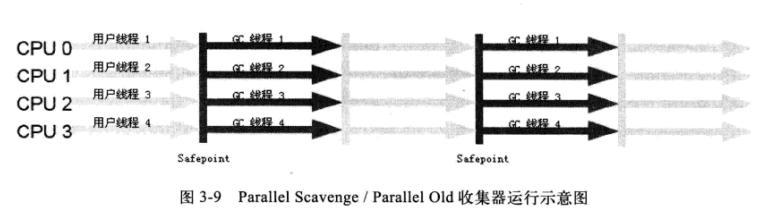

### CMS收集器

CMS（Concurrent Mark Sweep）收集器是一种以获得最短回收停顿时间为目标的收集器，这是一种划时代意义上的垃圾收集器，之所以这么说是因为之前的垃圾收集器无论是多线程的还是单线程的在垃圾回收过程中都需要将所有的用户线程都停止执行，这种Stop The World的行为无疑会造成很大的性能浪费，但是CMS垃圾回收器可以做到在垃圾回收的同时不暂停用户线程的执行，**这是其划时代的意义所在：第一次实现了真正的并发垃圾收集**，其工作原理图如下所示：

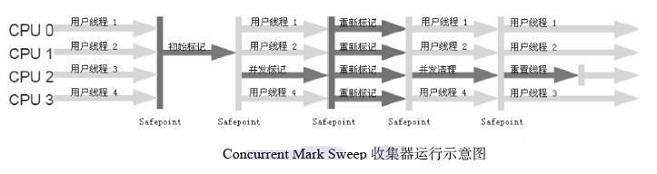

CMS垃圾回收器工作过程大致分为四个步骤：

1. 初始标记（CMS initial mark）：这一阶段**需要Stop The World**，初始标记仅仅只是记录一下GC Roots能**直接**关联到的对象，速度非常快。

2. 并发标记（CMS concurrent mark）:这一阶段不需要将用户线程停止，该阶段耗时较长，该阶段需要做完整的GC Roots Tracing过程，也就是需要找出完整的GC Roots对象的引用链，虽然时间较长，但是由于其可以与用户线程并发执行因此并不会带来过多的负面影响。

3. 重新标记（CMS remark）：第一阶段**需要Stop The World**。这一过程是为了修正并发标记期间因用户继续运作而导致标记产生变动的那一部分标记记录。

4. 并发清除（CMS concurrent sweep）：这一阶段就是多线程并发清除内存垃圾。

然而，CMS垃圾回收器也有以下三个明显的缺点：

1. CMS收集器对CPU资源非常敏感：在并发垃圾收集阶段或者并发标记阶段CMS与用户线程并发执行，这样会与用户线程竞争CPU资源从而导致应用程序变慢，总的吞吐量降低。

2. CMS收集器在并发清除阶段是与用户线程并发执行的，并不需要Stop The World，可能会产生无法处理的**“浮动垃圾”**，所谓浮动垃圾就是CMS在进行并发清理时用户线程产生的内存垃圾，这些内存垃圾无法在此次清除中清理，只好留待下一次清理过程清除。正是由于标记清理阶段用户线程依然在运行，因此标记清理的时机选取就很重要，不能让老年代中没有剩余内存在进行清理，这样就会导致用户线程无法运行，通常是在老年代剩余8%时触发垃圾回收，但是如果在回收过程中老年代内存耗尽，就会出现`Concurrent Mode Failure`，此时就需要Serial Old收集器来补救。

3. 最后一个缺点是不同于大多数老年代收集器采用的是标记整理算法，CMS老年代采用的是标记清理算法，这种算法会产生大量的内存碎片，有时在进行内存压紧的过程中会产生过多的时间消耗。

### G1收集器

G1(Garbage First)垃圾收集器是当今收集器技术发展的最前沿成果之一。G1是一款面向服务端的垃圾收集器，G1依然保留了新生代老年代的概念，但是G1不需要其他任何收集器的配合就能够管理整个Java堆内存。G1是Garbage First的缩写，G1收集器将内存分为多个小小相等的独立区域（Region），虽然还有新生代和老年代的概念，但是新生代和老年代已经不是相互物理隔离的内存区域了，他们都是一部分Region（不需要连续）的集合，所谓First就是G1收集器会判断不同Region里面内存垃圾回收价值的大小，然后维护一个优先列表，每次根据允许的收集时间，优先回收价值最大的Region，这样的收集策略保证了G1收集器在有限的时间内可以获得尽可能高的收集效率。

G1收集器有以下几个优点：

1. 并行与并发：G1收集器是一个多线程并发的垃圾收集器，能够充分利用底层的硬件资源来缩短Stop The World的时间。

2. 分代收集：G1垃圾回收器依然保留了内存分代的概念（新生代和老年代），它采用不同的方式去处理新创建的对象和已经存活了一段时间的对象（分别对应新生代对象和老年代对象）

3. 空间整合：和CMS采用标记清理算法不同，G1垃圾收集器从整体上来看采用“标记整理”算法，从局部（两个Region）上来看采用的是基于“复制”算法实现的。这两种算法使得G1收集器不会产生大量的内存碎片。

4. 可预测的停顿：G1收集器能让使用者在一个长度为M毫秒的时间片段内，消耗在垃圾收集上的时间不超过N毫秒，这几乎已经是实时Java的垃圾收集器特征了，这一特点正是由上面所说的G1能够对不同的Region垃圾回收价值做判断，然后选择收集其中价值较大Region特征来保证（如果要求停顿时间少，那么就选择回收价值最大的几个Region，如果停顿时间要求不是那么强，那么就选择多回收几个Region）。

G1收集器的难点在于不同的Region之间并不是独立的，而是存在错综复杂的引用关系的，因此在垃圾收集的过程中就会带来更多的挑战，G1收集器的收集步骤与CMS收集器相似：

1. 初始标记（Initial Marking）

2. 并发标记（Concurrent Marking）

3. 最终标记（Final Marking）

4. 筛选回收（Live Data Counting And Evacuation）

其工作流程如下所示：

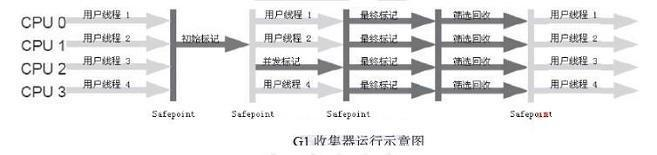

# 第六章 类文件结构

## 背景知识

>`Class`文件是一组以8字节为基础单位的二进制流，各个数据项目严格按照顺序紧凑排列在`Class`文件中。

> 无符号数属于基本数据类型，以`u1`,`u2`,`u4`,`u8`分别代表一个字节，两个字节，四个字节和八个字节的无符号数，无符号数可以用来描述数字，索引引用，数量值或者按照UTF8编码构成的字符串值。

本章以以下Java代码为例：

```Java
public class App {
    private int m;
    private int n = 123;
    public int inc(){
        return m + 1;
    }
}
```

然后使用`javac`对其进行编译，得到如下字节码：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
0x0000 | CA  FE  BA  BE  00  00  00  37  00  16  0A  00  05  00  11  09  
0x0010 | 00  04  00  12  09  00  04  00  13  07  00  14  07  00  15  01  
0x0020 | 00  01  6D  01  00  01  49  01  00  01  6E  01  00  06  3C  69  
0x0030 | 6E  69  74  3E  01  00  03  28  29  56  01  00  04  43  6F  64  
0x0040 | 65  01  00  0F  4C  69  6E  65  4E  75  6D  62  65  72  54  61  
0x0050 | 62  6C  65  01  00  03  69  6E  63  01  00  03  28  29  49  01  
0x0060 | 00  0A  53  6F  75  72  63  65  46  69  6C  65  01  00  08  41  
0x0070 | 70  70  2E  6A  61  76  61  0C  00  09  00  0A  0C  00  08  00  
0x0080 | 07  0C  00  06  00  07  01  00  03  41  70  70  01  00  10  6A  
0x0090 | 61  76  61  2F  6C  61  6E  67  2F  4F  62  6A  65  63  74  00  
0x00A0 | 21  00  04  00  05  00  00  00  02  00  02  00  06  00  07  00  
0x00B0 | 00  00  02  00  08  00  07  00  00  00  02  00  01  00  09  00  
0x00C0 | 0A  00  01  00  0B  00  00  00  27  00  02  00  01  00  00  00  
0x00D0 | 0B  2A  B7  00  01  2A  10  7B  B5  00  02  B1  00  00  00  01  
0x00E0 | 00  0C  00  00  00  0A  00  02  00  00  00  01  00  04  00  04  
0x00F0 | 00  01  00  0D  00  0E  00  01  00  0B  00  00  00  1F  00  02  
0x0100 | 00  01  00  00  00  07  2A  B4  00  03  04  60  AC  00  00  00  
0x0110 | 01  00  0C  00  00  00  06  00  01  00  00  00  06  00  01  00  
0x0020 | 0F  00  00  00  02  00  10
```

使用Java自带的字节码分析工具`javap`进行分析得到如下结果：

```shell
F:\>javap -verbose App
Classfile /F:/App.class
  Last modified 2019年3月21日; size 295 bytes
  MD5 checksum 93f039dc66d5bde9c66e5eaeae9bbe99
  Compiled from "App.java"
public class App
  minor version: 0
  major version: 55
  flags: (0x0021) ACC_PUBLIC, ACC_SUPER
  this_class: #4                          // App
  super_class: #5                         // java/lang/Object
  interfaces: 0, fields: 2, methods: 2, attributes: 1
Constant pool:
   #1 = Methodref          #5.#17         // java/lang/Object."<init>":()V
   #2 = Fieldref           #4.#18         // App.n:I
   #3 = Fieldref           #4.#19         // App.m:I
   #4 = Class              #20            // App
   #5 = Class              #21            // java/lang/Object
   #6 = Utf8               m
   #7 = Utf8               I
   #8 = Utf8               n
   #9 = Utf8               <init>
  #10 = Utf8               ()V
  #11 = Utf8               Code
  #12 = Utf8               LineNumberTable
  #13 = Utf8               inc
  #14 = Utf8               ()I
  #15 = Utf8               SourceFile
  #16 = Utf8               App.java
  #17 = NameAndType        #9:#10         // "<init>":()V
  #18 = NameAndType        #8:#7          // n:I
  #19 = NameAndType        #6:#7          // m:I
  #20 = Utf8               App
  #21 = Utf8               java/lang/Object
{
  public App();
    descriptor: ()V
    flags: (0x0001) ACC_PUBLIC
    Code:
      stack=2, locals=1, args_size=1
         0: aload_0
         1: invokespecial #1                  // Method java/lang/Object."<init>":()V
         4: aload_0
         5: bipush        123
         7: putfield      #2                  // Field n:I
        10: return
      LineNumberTable:
        line 1: 0
        line 4: 4

  public int inc();
    descriptor: ()I
    flags: (0x0001) ACC_PUBLIC
    Code:
      stack=2, locals=1, args_size=1
         0: aload_0
         1: getfield      #3                  // Field m:I
         4: iconst_1
         5: iadd
         6: ireturn
      LineNumberTable:
        line 6: 0
}
SourceFile: "App.java"
```

## 总体结构

* 魔数：用于标识字节码文件的特定信息，一共有4个字节，使用16进制表示为`0xCAFEBABE`。
* 版号：用于标识该字节码文件是由什么版本的虚拟机编译而成的。
* 常量池：存放该字节码文件中所要用到的全部常量，在常量池中常量的索引从1开始。
  1. 常量个数：使用2个字节标识常量池中常量的个数，真实的个数是该字段值减一。
  2. 常量：JDK1.7中一共定义了11中常量，用于字节码中各个部分使用。
* 访问标志：用于标识该类的访问信息，包括该类是否为`private`，是否有`final`关键字修饰。
* 类索引：用于标识该类的名称，该类的父类，以及该类所实现的接口。
  1. 本类索引：索引到常量池中的一个常量，标识该类的字符串名称。
  2. 父类索引：索引到常量池的一个`CONSTANT_Class_info`常量，标识该类的父类字符串名称。
  3. 接口索引数目：由于一个类可以实现多个接口，因此该字段用于标识接口索引集中接口的数目。
  4. 接口索引（可选）：用于索引到常量池的一个常量，标识接口名称。
* 字段表集合：用于标识该类中所有的字段信息。
  1. 字段表集合数目：标识字段表集合的数目。
  2. 字段表：用于描述一个字段的具体信息，包括访问控制，类型，名称等等。
* 方法表集合：用于标识该类中所有的方法信息。
  1. 方法表集合大小：用于标识方法表集合中方法表的数目。
  2. 方法表：描述一个方法的简单名，描述符，访问控制信息以及代码信息等。
* 类属性：描述类的一些特性，比如原文件名称等。

## 字节码文件详细结构

Java源代码编译而成的字节码按照非常紧凑的结构组成，被Java虚拟机按照字节为单位进行解释。Java字节码的组成部分按照出现先后顺序如下所示：

### 魔数

这是Java字节码中一个标识符号，意在告诉Java虚拟机这是一个字节码文件。它的取值是固定的：字节码文件的开头四个字节，以十六进制解析成`0xCAFEBABE`字样，不知道是不是呼应了Java语言的logo。

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
0x0000 | CA  FE  BA  BE  ...
```

### 版号

版号字段紧接着魔数字段，用四个字节来表示，意在表明该字节码文件使用什么版本的虚拟机编译而来。通常JDK1.1虚拟机的编号为45，以后每一个大版本的JDK都在版号后加一，例如JDK1.11的版号就为55。

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
0x0000 |            ...  00  00  00  37  ...
```

上面的字节码的版号为`0x0037`，转化为十进制就是55，表明该字节码使用JDK1.11编译而来。

### 常量池

字节码的接下来部分用于表示常量。常量在字节码文件中起到表示常量，标识字段意义的作用，例如存储方法名字符串，说明字节码的某个部分是什么意义等作用。在具体的常量表开始之前，字节码首先使用两个字节表示常量池的长度，需要注意的是常量池中的常量以`1`为开始索引，而不是通常的`0`，因此真是的常量个数是字节码中常量池个数的减一。

#### 常量池个数

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
0x0000 |                                ...  00  16   ...
```
可以看到：该字节码的常量池个数是`0x16`，则真正的常量个数为`0x16(22)-1=21`个。

#### 常量

字节码中的常量也是按照字节紧凑排列的，JDK1.7中一共规定了11中结构不同的常量。以该字节码文件为例：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
0x0000 |                                    ...  0A  00  05  00  11  ...
```
可以看到，该常量的`tag`值为`0x0A`查表得，该常量类型为`CONSTANT_Methodref_info`，其表结构为：

|项目|类型|描述|
|:-:|:-:|:-:|
|tag|u1|取值为10|
|index|u2|指向声明方法的类描述符`CONSTANT_Class_info`的索引项|
|index|u2|指向名称及类型描述符`CONSTANT_NameAndType`的索引项|

由字节码中的信息可以看到，该`CONSTANT_Methodref_info`的第一个索引值为`0x0005`，第二个索引值为`17(0x0011)`，分别代表了常量池中的第5个常量和第17个常量。查看`javap`中输出的信息：

```shell
...
   #1 = Methodref          #5.#17         // java/lang/Object."<init>":()V
   #2 = Fieldref           #4.#18         // App.n:I
   #3 = Fieldref           #4.#19         // App.m:I
   #4 = Class              #20            // App
   #5 = Class              #21            // java/lang/Object
   #6 = Utf8               m
   #7 = Utf8               I
   #8 = Utf8               n
   #9 = Utf8               <init>
  #10 = Utf8               ()V
  #11 = Utf8               Code
  #12 = Utf8               LineNumberTable
  #13 = Utf8               inc
  #14 = Utf8               ()I
  #15 = Utf8               SourceFile
  #16 = Utf8               App.java
  #17 = NameAndType        #9:#10         // "<init>":()V
  #18 = NameAndType        #8:#7          // n:I
  #19 = NameAndType        #6:#7          // m:I
  #20 = Utf8               App
  #21 = Utf8               java/lang/Object
...
```
`javap`字节码分析中输出的信息也表明：第一项`Methodref`的索引为`#5.#17`，这和我们计算出的一样。

* `Methodref`的第二个索引值索引到第`#5`项常量是一个`CONSTANT_Class_info`型，其又索引到`#21`项是一个字符串，其值为`java/lang/Object`。

* `Methodref`的第二个索引值索引到第`#17`个常量，该常量是一个`NameAndType`型，用于标识方法的描述符，可以看到第`#17`项常量和`#9`和`#10`都有关，这两个常量都是字符串类型，其值分别为`<init>`和`()V`。

其实`javap`分析器已经将`#1`号常量的值计算出来了：`java/lang/Object."<init>":()V`

在这里还要简述Java中表示类型的规则：

* 通常对于基本类型，例如`int`，`double`等，使用大写的`I`或`D`来表示，对于`void`这种特殊类型就使用`V`表示。

* 而对于Java中的对象类型，例如`String`类型，使用`Ljava.lang.String`表示，前面的`L`表示对象类型。

* 如果是数组的话，例如一个整形数组则使用`[I`来表示，如果是字符串数组则使用`[Ljava.lang.String`，需要注意的是，这只是一维数组，如果是二维则使用`[[Ljava.lang.String`。

Java字节码中描述对象方法的规则是：描述方法中参数的类型以及返回值类型。例如对于一个以下类型的方法

```Java
String getName(int index, double age, String[][] tag);
```
则可以表述成：

```shell
(ID[[Ljava.lang.String)Ljava.lang.String
```
刚才例子中的`()V`即代表该方法没有参数且返回值为`void`。

### 访问标志

在常量池结束之后紧接着是访问标志：`ACCESS_Flag`。这个标志标识着该类是否为`public`等信息，这个访问标志使用两个字节表示，在该例子中：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
                              ... 
0x0090 |                                                        ...  00  
0x00A0 | 21 ...
```
该访问标志为：`0x0021`。

### 类索引，父类索引及接口索引集合

这个字段紧接着访问标志，用于标识该类属于的类，以及其父类和实现的接口信息。类索引和父类索引均使用一个字节表示，接口索引也使用一个字节表示，在接口索引出现之前先表示集合的大小。本例中的这些索引为：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
...
0x00A0 |...  00  04  00  05  00  00  ...
```
可以看到，该字节码的本类索引值为`0x0004`，父类索引值为`0x0005`分别索引到常量池中的第4个常量和第5个常量。查表得这两个常量都是`CONSTANT_Class_info`类型，代表`App`和`java.lang.Object`。而该类没有实现任何接口，因此接口索引集合的大小表示为`0x0000`，也就是没有接口索引。

### 字段表集合

这个集合紧接着接口索引集合，用于表示类中的字段，注意方法中的临时变量并不在这里表示，字段表的结构如下所示：

|类型|名称|数量|备注|
|:-:|:-:|:-:|:-:|
|u2|access_flags|1|访问标志位，用于标识该字段是否为`private`这样的信息|
|u2|name_index|1|该字段的简单名称|
|u2|descriptor_index|1|该字段的描述符，值类型|
|u2|attributes_count|1|属性集个数|
|attribute_info|attributes|attributes_count|具体的属性|

本例中有两个字段分别是`m`和`n`，字节码中的表示为：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
-----------------------------------------------------------------------
...  
0x00A0 |                        ...  00  02  00  02  00  06  00  07  00  
0x00B0 | 00  00  02  00  08  00  07  00  00 ...
```
可以看到字段集合的起始为字段集合的大小，这里是`0x0002`，代表有两个字段。然后紧接着就是第一个字段的`ACCESS_Flag`这里的意义和类的`ACCESS_Flag`相似，随后的两个字段分别是常量索引，代表该字段的简名以及描述符（`0x0006, 0x0007`）,最后一个是该字段属性列表的大小，属性用于表示该字段的一些特殊特征，这里为`0x0000`也就是属性列表为空。

第二个字段的解释和上面完全一致。

### 方法表集合

方法表即一个类内部的各种方法的集合，它和字段表的结构非常相似，还是以文中的例子为例，其方法表集合如下面所示：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
----------------------------------------------------------------------- 
0x00B0 |                                ...  00  02  00  01  00  09  00  
0x00C0 | 0A  00  01  00  0B  00  00  00  27  00  02  00  01  00  00  00  
0x00D0 | 0B  2A  B7  00  01  2A  10  7B  B5  00  02  B1  00  00  00  01  
0x00E0 | 00  0C  00  00  00  0A  00  02  00  00  00  01  00  04  00  04  
0x00F0 | 00  01  00  0D  00  0E  00  01  00  0B  00  00  00  1F  00  02  
0x0100 | 00  01  00  00  00  07  2A  B4  00  03  04  60  AC  00  00  00  
0x0110 | 01  00  0C  00  00  00  06  00  01  00  00  00  06  00  01  ...
```
方发表的开头是方法表集合的大小，在这里是`0x0002`即为有两个方法表，接下来就进入方发表的正文部分，方法表的结构图下表所示：

|类型|名称|数量|备注|
|:-:|:-:|:-:|:-:|
|u2|access_flags|1|访问标志位，用于标识该方法是否为`private`这样的信息|
|u2|name_index|1|该方法的简单名称|
|u2|descriptor_index|1|该方法的描述符，包括特征标和返回值类型|
|u2|attributes_count|1|属性集个数|
|attribute_info|attributes|attributes_count|具体的属性|

在方法表中最重要的属性就是`Code`属性，它存放了该方法内容的全部编码。`Code`属性的表结构如下所示：

|类型|名称|数量|备注|
|:-:|:-:|:-:|:-:|
|u2|attribute_name_index|1|`Code`属性在常量表中的索引号|
|u4|attribute_length|1|属性的长度，注意：该长度不包含`attribute_name_index`和`attribute_length`两个字段|
|u2|max_stack|1|栈帧中操作数栈的最大深度|
|u2|max_locals|1|局部变量表的存储空间，单位为`slot`|
|u4|code_length|1|字节码的长度|
|u1|code|code_length|字节码的内容|
|u2|exception_table_length|1|异常表的长度|
|exception_info|exception_table|exception_tab;e_lenght|异常表的内容|
|u2|attributes_count|1|属性表长度|
|attribute_info|attributes|attributes_count|例如用于标识字节码与源代码行号对应关系的`LineNumberTable`属性|

最后，需要说一下方法表中的`max_locals`字段，该字段表示局部变量表中的存储空间，其基本单位为`slot`，这是Java虚拟机中存储分配的最基本单位，如果是`int`,`char`这样的数据类型，那么就会给其分配一个`slot`，而如果是`double`或`long`型那么就会分配两个`slot`。有的方法即使没有内部变量但是其`max_locals`也不为0，例如：

```shell
public int inc();
    descriptor: ()I
    flags: (0x0001) ACC_PUBLIC
    Code:
      stack=2, locals=1, args_size=1
         0: aload_0
         1: getfield      #3                  // Field m:I
         4: iconst_1
         5: iadd
         6: ireturn
      LineNumberTable:
        line 6: 0
```

`inc`方法没有局部变量，方法中引用的是类的字段，但是它的`max_locals`却不为0，这是因为类中的方法都有一个`this`对象，这个对象在方法中是隐式传入的，`max_locals`中的变量指的就是`this`对象。

### 类属性

方法表集合结束后就是类属性，在本例中类属性如下所示：

```shell
offset |  0   1   2   3   4   5   6   7   8   9   A   B   C   D   E   F
----------------------------------------------------------------------- 
0x0110 |                                                        ...  00  
0x0020 | 0F  00  00  00  02  00  10
```
查常量表可知`0x000F`是一个`SourceFile`类型的表，根据`SourceFile`表的结构可得该属性的值为：`App.java`